## Линейная классификация

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [101]:
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [102]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Смотрим на SVM, LR 

In [103]:
# Сгенерируем синтетические данные.
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

In [104]:
X.shape

(10000, 10)

✅
- Обучите метод опорных векторов. 
- Подберите параметр регуляризации `C`, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR

In [105]:
def auc_pr(y_test, y_pred):
    precision, recall, th = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [106]:
scl = StandardScaler()
X = scl.fit_transform(X)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [108]:
def c_best_selection(C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0

    for C_i in C_set:
        clf.C = C_i

        clf.fit(X_t, y_t)
        a_x = clf.predict(X_val)

        precision, recall, th = precision_recall_curve(y_val, a_x)

        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i

    print("Подобранный параметр С:", C)
    return C


In [109]:
best_c_linearSVC = c_best_selection(np.arange(0.001, 100, 1), LinearSVC(), X_train1, y_train1, X_val, y_val)

Подобранный параметр С: 0.001


✅ На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

### Считаем

In [110]:
clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

In [111]:
precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

In [112]:
print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f" % auc(recall, precision))

AUC_ROC: 0.77199
AUC_PR: 0.83159


In [113]:
fpr

array([0.      , 0.229265, 1.      ])

### Строим

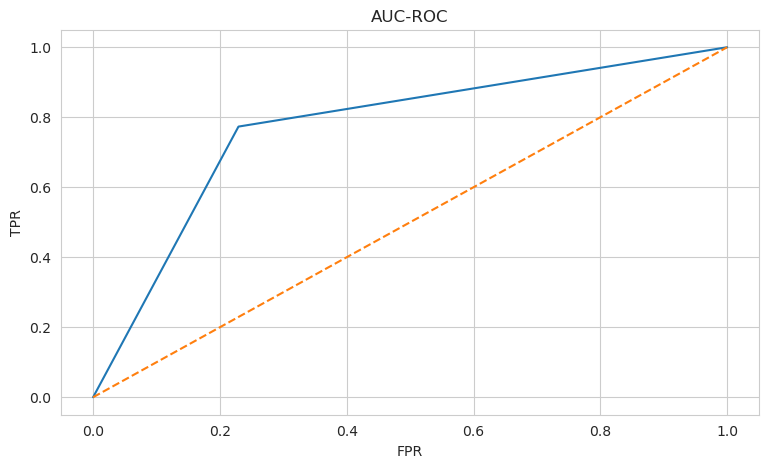

In [114]:
plt.figure(figsize=(9, 5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [115]:
recall

array([1.        , 0.77323665, 0.        ])

In [116]:
precision

array([0.50566667, 0.7752809 , 1.        ])

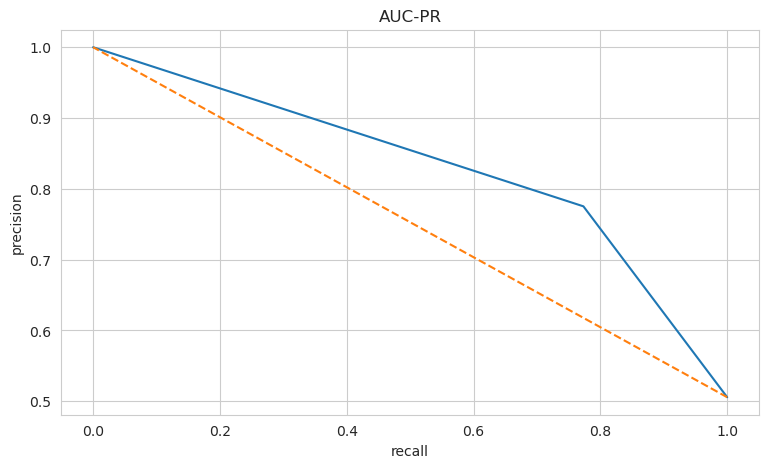

In [117]:
plt.figure(figsize=(9, 5))

plt.plot(recall, precision, label="PR")
plt.plot([1, 0], [precision[0], 1], linestyle='--')

plt.grid(True)
plt.title('AUC-PR')
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

✅ 
- Проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. 
- Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества.

In [118]:
best_c_LR = c_best_selection(np.arange(0.001, 100, 1), LogisticRegression(), X_train1, y_train1, X_val, y_val)

Подобранный параметр С: 1.001


In [119]:
clf = LogisticRegression()
clf.C = best_c_LR
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f" % auc(recall, precision))

AUC_ROC: 0.77134
AUC_PR: 0.83116


### Строим

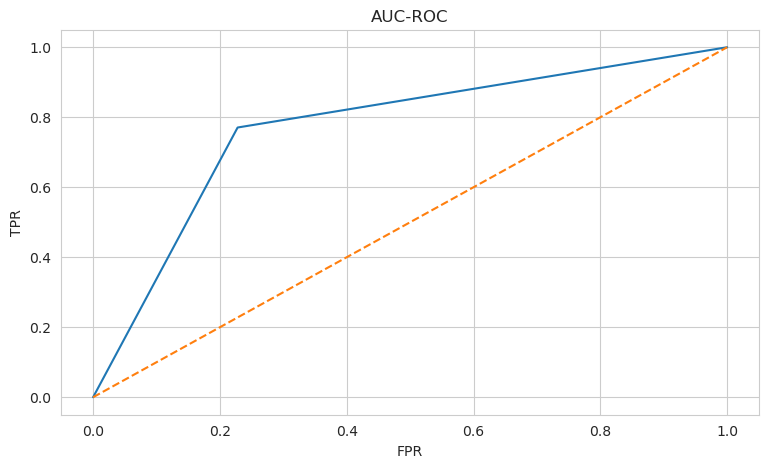

In [120]:
plt.figure(figsize=(9, 5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [121]:
precision

array([0.50566667, 0.77571334, 1.        ])

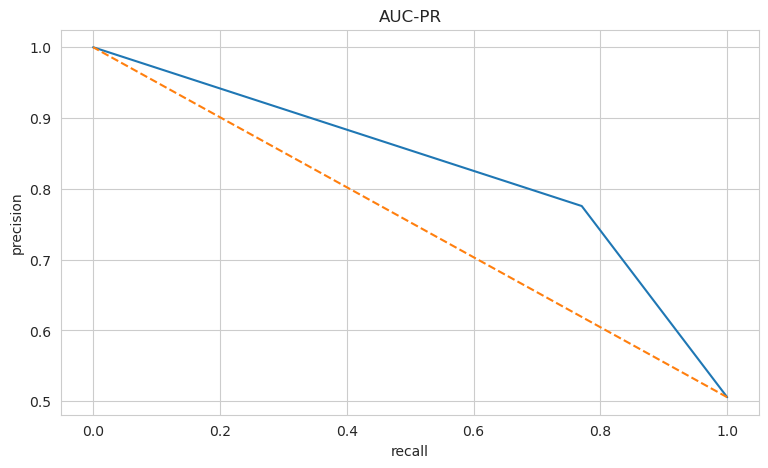

In [122]:
plt.figure(figsize=(9, 5))

plt.plot(recall, precision, label="PR")
plt.plot([1, 0], [precision[0], 1], linestyle='--')

plt.grid(True)
plt.title('AUC-PR')
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

# 📌 Работаем с признаками


Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

✅ Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

In [123]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [124]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [125]:
df.shape

(41188, 21)

✅ 
 - Разделите выборку на обучающую и тестовую в соотношении 3:1. 
 - Зафиксируйте `random_state=777`, используйте `stratify`.
 - Удалите столбец, который не несет информации для решения задачи. 



In [126]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

In [127]:
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1

In [128]:
df.shape

(41188, 21)

✅ 
- Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

- Почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

**Разделим признаки на категориальные и вещественные**

In [129]:
cat = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['duration', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

### Подготовка к обучению модели

In [130]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [131]:
#для кодирования категориальных признаков используем OrdinalEncoder
enc = OrdinalEncoder()

In [132]:
#вещественные признаки также отмасштабируем
data = ColumnTransformer([
    ('cat', enc, cat),
    ('num', StandardScaler(), num)
])

#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
    ('enc_and_st_scaler', data),
    ('classifier', LogisticRegression())
])

### Переходим к обучению 

In [133]:
df_ = pd.DataFrame({'name': ['n', 'n', 'v', 'm', 'v', 'n']})

In [134]:
df_

,name
0,n
1,n
2,v
3,m
4,v
5,n


In [135]:
enc.fit_transform(df_)

array([[1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [1.]])

In [136]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                                    df['y'], test_size=0.3,
                                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [137]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OrdinalEncoder:', time.time() - start_time)
print('AUC-PR на OrdinalEncoder = %.5f' % auc_pr(y_test, y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OrdinalEncoder: 0.15352463722229004
AUC-PR на OrdinalEncoder = 0.96217
Кол-во столбцов 20


In [138]:
model

Pipeline(steps=[('enc_and_st_scaler',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'age',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.conf.idx',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed'])])),
                ('classifier', LogisticRegression())])

✅
- Закодируйте все категориальные признаки с помощью one-hot-кодирования. 
- Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). 
- Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [139]:
#для кодирования категориальных признаков используем OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")

#вещественные признаки также отмасштабируем
data = ColumnTransformer([
    ('cat', enc, cat),
    ('num', StandardScaler(), num)
])

#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
    ('enc_and_st_scaler', data),
    ('classifier', LogisticRegression())
])

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                                    df['y'], test_size=0.3,
                                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [141]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OHE:', time.time() - start_time)
print('AUC-PR на OHE = %.5f' % auc_pr(y_test, y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OHE: 0.25958847999572754
AUC-PR на OHE = 0.96287
Кол-во столбцов 63


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории. Метод предполагает кодирование категорий средним арифметическим от суммы целевых меток
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$



✅ 
- Закодируйте категориальные переменные с помощью счётчиков:

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

- Обучите логистическую регрессию и посмотрите на качество модели на тестовой выборке. 
- Сравните с предыдущими экспериментами

In [142]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
data = ColumnTransformer([
    ('cat', 'passthrough', cat),
    ('num', StandardScaler(), num)
])

#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
    ('enc_and_st_scaler', data),
    ('classifier', LogisticRegression())
])

### Кодирование категориальных, обучение модели и тестирование

In [143]:
start_time = time.time()

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_train = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0] / X_train[X_train[col] == categ].shape[0]
        X_train.loc[X_train[col] == categ, col] = g_train

        g_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0] / X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_test

    #обучение, тестировние        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding = %.5f" % auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.6187136173248291
AUC-PR при mean-target encoding = 0.96173
Кол-во столбцов  20


✅
- Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям . 
- Снова обучите логистическую регрессию, оцените качество. 
- Сделайте выводы.


In [144]:
start_time = time.time()
for col in cat:
    #добавим шума к категориальным признакам
    X_train[col] += np.random.rand(X_train.shape[0]) * np.sign(np.random.rand(X_train.shape[0]) - 0.5) / 10
    X_test[col] += np.random.rand(X_test.shape[0]) * np.sign(np.random.rand(X_test.shape[0]) - 0.5) / 10

clf = LogisticRegression()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding и шуме= %.5f" % auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.1867978572845459
AUC-PR при mean-target encoding и шуме= 0.96163
Кол-во столбцов  20


✅ Добавьте сглаживание, а затем повторите эксперименты.

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

In [145]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                                    df['y'], test_size=0.3, random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [146]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
date = ColumnTransformer([
    ('cat', 'passthrough', cat),
    ('num', StandardScaler(), num)
])

#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
    ('enc_and_st_scaler', date),
    ('classifier', LogisticRegression())
])

In [147]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса (global_mean)
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса (global_mean)
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" % auc_pr(y_test, y_pred))

Время на обучение модели: 0.6090338230133057
AUC-PR при global mean = 0.96451


✅ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [148]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                                    df['y'], test_size=0.3, random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [149]:
print('Кол-во уникальных возрастов', df['age'].nunique())

Кол-во уникальных возрастов 78


In [150]:
#теперь возраст категориальная переменная
cat = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration']

In [151]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" % auc_pr(y_test, y_pred))

Время на обучение модели: 0.696875810623169
AUC-PR при global mean = 0.97287


**Заметим, что AUC_PR стала выше**

**Домашнее задание**

✅ Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 11, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [152]:
X = df

In [153]:
cat = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'month', 'day_of_week',
       'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [154]:
# посмотрим на уникальные значения в столбцах month и day_of_week
print(X['month'].unique())
print(X['day_of_week'].unique())

['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
['mon' 'tue' 'wed' 'thu' 'fri']


In [155]:
# интерпретируем месяц и день недели как числовые
X['month'] = X['month'].map({'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4,
                             'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9,
                             'nov': 10, 'dec': 11})
X['day_of_week'] = X['day_of_week'].map({'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4})

In [156]:
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,4,0,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,4,0,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,4,0,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,4,0,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,4,0,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,10,4,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,10,4,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,56,retired,married,university.degree,no,yes,no,cellular,10,4,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41186,44,technician,married,professional.course,no,no,no,cellular,10,4,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [157]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='y'),
                                                    X['y'], test_size=0.3, random_state=777, stratify=X['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [158]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" % auc_pr(y_test, y_pred))

Время на обучение модели: 0.7274906635284424
AUC-PR при global mean = 0.97249


In [159]:
# результаты ухудшились, модель может интерпретировать признаки как порядковые (с порядком и расстоянием между значениями), что не всегда корректно. Например, числовая разница между "январем" и "декабрем" будет значительной, хотя в реальности они следуют друг за другом. Это может привести к ухудшению предсказательных возможностей модели

# 📌 Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [160]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [161]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1


✅ В данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

### Вспомним как были разделены признаки (на вещественные и категориальные)

In [162]:
cat = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration']

### Закодируем категориальрные признаки с помощью one-hot кодирования

**Будем использовать метод get_dummies**

In [163]:
#для красивого вывода названий столбцов
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns=cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_mask, drop_first=True)

In [164]:
X_train.shape

(28831, 52)

✅ В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. 

In [165]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

auc_pr_lr_ohe = auc_pr(y_test, a_x)

In [166]:
print("AUC_PR = %.5f" % auc_pr_lr_ohe)

AUC_PR = 0.95224


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.





✅ 
 - Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? 

In [167]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время обучения модели', time.time() - start_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)

Время обучения модели 0.2363290786743164
AUC_PR = 0.95192


In [168]:
# стало хуже, так как модель не учитывает взаимодействие признаков, а отбор происходит по величине весов

In [169]:
indices

Index([16, 48, 44, 37, 51, 29, 45, 38, 17, 18,  0, 14, 11, 22, 33, 26, 31, 12,
       19,  2, 23, 10, 34, 32,  8, 27, 35, 25, 43, 15, 24, 20, 46,  3, 30,  9,
       36,  4,  7, 42],
      dtype='int64')

### Отмасшабируем признаки с помощью StandartScaler и OHE

**Снова разделим данные**

In [170]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Кодирование

In [171]:
#вещественные признаки отмасштабируем с помощью StandardScaler, категориальные пока не трогаем
date = ColumnTransformer([
    ('cat', 'passthrough', cat),
    ('num', StandardScaler(), num)
])

X_train = pd.DataFrame(date.fit_transform(X_train))
X_test = pd.DataFrame(date.transform(X_test))

In [172]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, columns=X_train.iloc[:, 0:10].columns, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=X_test.iloc[:, 0:10].columns, drop_first=True)

In [173]:
X_train

,10,11,12,13,14,15,16,17,18,19,0_blue-collar,0_entrepreneur,0_housemaid,0_management,0_retired,0_self-employed,0_services,0_student,0_technician,0_unemployed,0_unknown,1_married,1_single,1_unknown,2_basic.6y,2_basic.9y,2_high.school,2_illiterate,2_professional.course,2_university.degree,2_unknown,3_unknown,3_yes,4_unknown,4_yes,5_unknown,5_yes,6_telephone,7_aug,7_dec,7_jul,7_jun,7_mar,7_may,7_nov,7_oct,7_sep,8_mon,8_thu,8_tue,8_wed,9_nonexistent,9_success
0,-0.289536,-0.567466,0.196418,-0.351015,-2.213588,2.249459,-1.599578,-1.669748,-2.061837,-0.035962,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False
1,-0.958139,-0.567466,0.196418,1.665344,-1.131825,0.477886,0.781528,-1.563255,-2.419431,-0.392675,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,1.62076,-0.203565,0.196418,-0.351015,-0.113695,-0.321482,-0.647481,0.233315,0.399899,-0.477976,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,0.570097,-0.567466,0.196418,1.665344,-1.195458,-1.228873,-1.17796,-1.352571,-0.93521,-0.291865,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
4,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.719154,0.845855,1.247428,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.718579,0.845855,-0.160036,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
28827,-0.76711,-0.567466,0.196418,-0.351015,0.840802,0.953186,-0.225863,0.778445,0.845855,0.130762,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
28828,-0.480565,0.160335,0.196418,-0.351015,0.840802,-0.472714,0.593182,0.774991,0.845855,-0.29962,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
28829,0.761127,-0.567466,0.196418,-0.351015,-1.195458,-1.228873,-1.17796,-1.313427,-0.93521,-0.536136,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False


**Теперь выберем 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модель, оценим её качество.**

In [174]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [175]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [176]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(53)]).sort_values(by=0).tail(40).index  #Выбрали 40 лучших весов

x_train = X_train.iloc[:, indices.values]  #выбрали признаки, соответствующие лучшим весам
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" % auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.08627939224243164
AUC-PR (40 признаков) = 0.95300
indices = Index([49, 46, 22, 29, 12, 30, 23, 48,  5, 19,  8, 21,  0, 18, 40, 25, 26, 34,
       28, 32, 13, 20,  3, 36, 11, 35, 33, 45,  1, 15, 16,  2, 47, 10, 31, 41,
       44, 43, 37,  4],
      dtype='int64')


**Домашнее задание**

✅ one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [177]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [178]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)

In [179]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
38757,37,1,999,0,-3.4,92.649,-30.1,0.715,5017.5,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False
40369,30,1,999,1,-1.7,94.027,-38.3,0.900,4991.6,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
27545,57,2,999,0,-0.1,93.200,-42.0,4.021,5195.8,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
34606,46,1,999,1,-1.8,92.893,-46.2,1.266,5099.1,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
7869,55,2,999,0,1.4,94.465,-41.8,4.865,5228.1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8288,55,2,999,0,1.4,94.465,-41.8,4.864,5228.1,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
19135,32,1,999,0,1.4,93.444,-36.1,4.968,5228.1,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
17470,35,3,999,0,1.4,93.918,-42.7,4.962,5228.1,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
31124,48,1,999,0,-1.8,92.893,-46.2,1.334,5099.1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False


In [180]:
#вещественные признаки отмасштабируем с помощью StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [181]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [182]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index  #Выбрали 40 лучших весов

x_train = X_train.iloc[:, indices.values]  #выбрали признаки, соответствующие лучшим весам
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" % auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.0391542911529541
AUC-PR (40 признаков) = 0.95216
indices = Index([20, 48,  0, 13, 38, 16, 22, 29, 45, 28, 26, 18, 17, 11, 24, 10, 12, 33,
       14, 34, 32, 39, 25, 35, 44, 19,  3, 15, 27, 46,  9, 31,  1, 30, 43,  2,
       40, 42, 36,  4],
      dtype='int64')


In [183]:
# качество ухудшилось, так как признаки были отмасштабированы, а веса модели остались без изменений

**Домашнее задание**

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.




✅ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.

In [184]:
from math import sqrt

In [185]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [186]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, drop_first=True).astype(int)
X_test = pd.get_dummies(data=X_test, drop_first=True).astype(int)

In [187]:
X_train

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
38757,37,248,1,999,0,-3,92,-30,0,5017,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
40369,30,156,1,999,1,-1,94,-38,0,4991,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27545,57,134,2,999,0,0,93,-42,4,5195,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
34606,46,182,1,999,1,-1,92,-46,1,5099,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7869,55,579,2,999,0,1,94,-41,4,5228,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8288,55,216,2,999,0,1,94,-41,4,5228,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
19135,32,291,1,999,0,1,93,-36,4,5228,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
17470,35,180,3,999,0,1,93,-42,4,5228,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
31124,48,119,1,999,0,-1,92,-46,1,5099,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [188]:
# создади функцию для подсчета t-статистики
def t_stat(X, y):
    t_stat_arr = []
    for col in X.columns:
        
        # разделим данные на 2 класса
        class_0 = X[y == 0][col]
        class_1 = X[y == 1][col]
        
        # посчитаетаем среднее, стандартное отклонение и количество объектов каждого из классов
        mu_0, sigma_0, n_0 = class_0.mean(), class_0.std(), class_0.shape[0]
        mu_1, sigma_1, n_1 = class_1.mean(), class_1.std(), class_1.shape[0]
        
        # посчитаетаем t значение для этой фичи
        t = abs(mu_1 - mu_0) / sqrt((n_1 * sigma_1 ** 2 + n_0 * sigma_0 ** 2) / (n_1 + n_0))
        t_stat_arr.append(t)
    return np.array(t_stat_arr)

In [189]:
start_time = time.time()

# рассчитаем t-статистику для каждого признака

t_stat_values = t_stat(X_train, y_train)

t_stat_df = pd.DataFrame(t_stat_values, index = X_train.columns, columns=['t_stat'])
indices = t_stat_df.sort_values(by='t_stat', ascending = False).head(40).index

X_train = X_train[indices]
X_test = X_test[indices]

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

auc_pr_lr_40 = auc_pr(y_test, y_pred)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_40)
print('Выбранные признаки:', indices.tolist())

Время на обучение модели: 0.4823756217956543
AUC-PR (40 признаков) = 0.96171
Выбранные признаки: ['duration', 'nr.employed', 'euribor3m', 'pdays', 'poutcome_success', 'emp.var.rate', 'previous', 'poutcome_nonexistent', 'contact_telephone', 'month_mar', 'month_oct', 'month_sep', 'month_may', 'default_unknown', 'job_retired', 'job_student', 'month_dec', 'job_blue-collar', 'campaign', 'cons.price.idx', 'cons.conf.idx', 'education_university.degree', 'marital_single', 'education_basic.9y', 'age', 'marital_married', 'month_jul', 'job_services', 'day_of_week_mon', 'education_unknown', 'job_unemployed', 'education_basic.6y', 'day_of_week_thu', 'job_entrepreneur', 'housing_yes', 'month_nov', 'day_of_week_tue', 'job_technician', 'marital_unknown', 'day_of_week_wed']


In [190]:
# AUC-PR увеличился, так как мы учитываем взаимодействие признаков

**Домашнее задание**

### Методы-обёртки


Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).


✅ Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [201]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns=cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns=cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

### Начинаем отбор

In [202]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
import time

model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=40)

rfe.fit(X_train1, y_train1)

X_train_selected = X_train1.loc[:, rfe.support_]
X_val_selected = X_val.loc[:, rfe.support_]

model.fit(X_train_selected, y_train1)

y_val_pred = model.predict(X_val_selected)

auc_pr_elimination = auc_pr(y_val, y_val_pred)

print('Время на отбор признаков и обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" % auc_pr_elimination)
print('Отобранные признаки:', X_train_selected.columns.tolist())


Время на отбор признаков и обучение модели: 355.2827582359314
AUC-PR (40 признаков) = 0.95241
Отобранные признаки: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unknown', 'marital_single', 'education_basic.6y', 'education_high.school', 'education_illiterate', 'education_university.degree', 'default_unknown', 'default_yes', 'housing_yes', 'contact_telephone', 'month_aug', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success']


In [73]:
# стало дольше и хуже

✅ Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте добавлять по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. 

In [208]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns=cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns=cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

X_train_3 = pd.DataFrame()
X_test_3 = pd.DataFrame()
X_valid_3 = pd.DataFrame()

### Отбор данных

In [209]:
# т.к встроенного RFA нету в sklearn, то будем делать это вручную

In [212]:
start_time = time.time()

model = LogisticRegression()
selected_features = [] 
all_features = list(X_train1.columns) 



while len(selected_features) < 40:
    best_score = 0
    best_feature = None
    for feature in all_features:
        current_features = selected_features + [feature]
        model.fit(X_train1[current_features], y_train1)
        y_pred = model.predict(X_val[current_features])
        score = auc_pr(y_val, y_pred)
        if score > best_score:
            best_score = score
            best_feature = feature
    selected_features.append(best_feature)
    all_features.remove(best_feature)


model.fit(X_train1[selected_features], y_train1)
y_test_pred = model.predict(X_test[selected_features])

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
auc_pr_final = auc(recall, precision)

# Выводим время и финальное качество модели
print('Время на отбор признаков и обучение модели:', time.time() - start_time)
print("Финальный AUC-PR (40 признаков) = %.5f" % auc_pr_final)
print('Отобранные признаки:', selected_features)

Время на отбор признаков и обучение модели: 17.115450859069824
Финальный AUC-PR (40 признаков) = 0.95366
Отобранные признаки: ['pdays', 'emp.var.rate', 'job_self-employed', 'education_basic.6y', 'job_housemaid', 'job_management', 'job_retired', 'job_unknown', 'marital_unknown', 'education_illiterate', 'education_professional.course', 'default_yes', 'loan_yes', 'job_unemployed', 'euribor3m', 'month_mar', 'job_student', 'poutcome_nonexistent', 'month_oct', 'month_sep', 'marital_single', 'marital_married', 'housing_unknown', 'education_unknown', 'loan_unknown', 'education_high.school', 'month_aug', 'day_of_week_mon', 'job_entrepreneur', 'job_services', 'day_of_week_tue', 'previous', 'age', 'month_nov', 'default_unknown', 'job_technician', 'day_of_week_wed', 'housing_yes', 'month_dec', 'day_of_week_thu']


In [207]:
# качество модели улучшилось, но скорость также страдает